In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

from pylab import rcParams


# to move files from one directory to another
import shutil

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

In [3]:
data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/LandSat_NASA/"

# Read the data

In [4]:
EVI_8day = pd.read_csv(data_dir + "NASA_LandSt_8dayEVI.csv", low_memory = False)
# EVI_direct = pd.read_csv(data_dir + "NASA_LandSat_Tier1.csv", low_memory = False)

In [5]:
EVI_8day_IDS = list(EVI_8day.ID.unique())
EVI_8day_IDS

['108447_WSDA_SF_2017', '99423_WSDA_SF_2017', '107433_WSDA_SF_2017']

In [6]:
EVI_8day.head(2)

,ID,county,DataSrc,CropTyp,doy,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time
0,108447_WSDA_SF_2017,Grant,wsda,"corn, field",216.0,0.287852,rill,Alfalfa Hay,2017/07/11,NaN,1.470269e+12
1,108447_WSDA_SF_2017,Grant,wsda,"corn, field",224.0,0.257201,rill,Alfalfa Hay,2017/07/11,NaN,1.470960e+12


# Take Care of system_start_time
 - and add image year. This step needs to be done since image_year is used in the fill_theGap_linearLine(.) function.

In [7]:
EVI_8day = rc.add_human_start_time(EVI_8day)

# add image_year from human_system_start_time

In [8]:
EVI_8day["image_year"] = EVI_8day['human_system_start_time'].dt.year
EVI_8day['SF_year'] = 2017

In [9]:
EVI_8day.head(2)

,ID,county,DataSrc,CropTyp,doy,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time,human_system_start_time,image_year,SF_year
0,108447_WSDA_SF_2017,Grant,wsda,"corn, field",216.0,0.287852,rill,Alfalfa Hay,2017/07/11,NaN,1.470269e+09,2016-08-03,2016,2017
1,108447_WSDA_SF_2017,Grant,wsda,"corn, field",224.0,0.257201,rill,Alfalfa Hay,2017/07/11,NaN,1.470960e+09,2016-08-11,2016,2017


# Fill missing values in EVI and DoY

  **Fill missing DoYs first. We need this for linear interpolations of EVI**
   - First, replace missing <code>doy</code> using human_system_start_time.

  **Fill NAs in 8-day EVI**
   - second replace missing values of <code>EVI</code> with -1.5. These are the indicators for missing values that we used
   in the <code>fill_theGap_linearLine(.)</code> function.
   
   - lastly, fill missing values of <code>EVI</code>.
   
   

# Take care of missing DoYs

In [10]:
EVI_8day = rc.fill_missing_doi_for_8DayEVI_Landsat_from_human_system_time(EVI_8day)
EVI_8day.loc[188:190, ]

,ID,county,DataSrc,CropTyp,doy,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time,human_system_start_time,image_year,SF_year
188,107433_WSDA_SF_2017,Grant,wsda,"corn, field",312.0,0.254283,center pivot,Potato,2017/07/10,7-31-13 new cp,1.510186e+09,2017-11-08,2017,2017
189,107433_WSDA_SF_2017,Grant,wsda,"corn, field",320.0,NaN,center pivot,Potato,2017/07/10,7-31-13 new cp,1.510877e+09,2017-11-16,2017,2017
190,107433_WSDA_SF_2017,Grant,wsda,"corn, field",328.0,NaN,center pivot,Potato,2017/07/10,7-31-13 new cp,1.511568e+09,2017-11-24,2017,2017


In [11]:
EVI_8day["EVI"].fillna(-1.5, inplace=True)
EVI_8day.loc[188:190, ]

,ID,county,DataSrc,CropTyp,doy,EVI,Irrigtn,RtCrpTy,LstSrvD,Notes,system_start_time,human_system_start_time,image_year,SF_year
188,107433_WSDA_SF_2017,Grant,wsda,"corn, field",312.0,0.254283,center pivot,Potato,2017/07/10,7-31-13 new cp,1.510186e+09,2017-11-08,2017,2017
189,107433_WSDA_SF_2017,Grant,wsda,"corn, field",320.0,-1.500000,center pivot,Potato,2017/07/10,7-31-13 new cp,1.510877e+09,2017-11-16,2017,2017
190,107433_WSDA_SF_2017,Grant,wsda,"corn, field",328.0,-1.500000,center pivot,Potato,2017/07/10,7-31-13 new cp,1.511568e+09,2017-11-24,2017,2017


#### Reminder: <code>fill_theGap_linearLine(.)</code> works on one filed at a time.

In [12]:
EVI_8day_noGap = pd.DataFrame()

for a_field in EVI_8day_IDS:
    curr_field = EVI_8day[EVI_8day.ID == a_field].copy()
    curr_field = rc.fill_theGap_linearLine(regular_TS = curr_field, V_idx="EVI", SF_year=2017)
    EVI_8day_noGap = pd.concat([EVI_8day_noGap, curr_field])

# Plot

In [13]:
#
# plt.rc() sets the tone for everything once it is done.
#

rcParams['figure.figsize'] = 10, 12

title_FontSize = 15
legend_FontSize = 12
tick_FontSize = 18
label_FontSize = 22
#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'georgia')
# plt.rc('text', usetex = True)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15) # x-small


<Figure size 720x864 with 0 Axes>

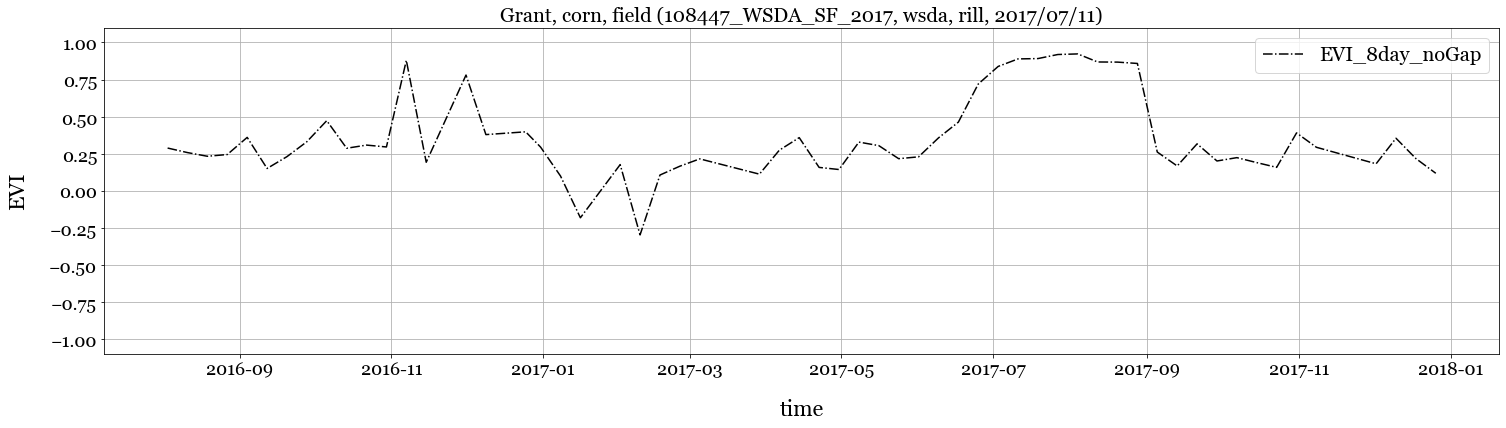

In [14]:
curr_ID = EVI_8day_IDS[0]
EVI_8day_noGap_field = EVI_8day_noGap[EVI_8day_noGap.ID == curr_ID].copy()

plt.figure()

fig, ax = plt.subplots()
fig.set_size_inches(25, 6)

################################################
#
#   plot the data
#

x = EVI_8day_noGap_field.human_system_start_time.values
y = EVI_8day_noGap_field.EVI.values
ax.plot(x, y, '-k', ls='-.', label = 'EVI_8day_noGap')


################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = label_FontSize, labelpad=20);
ax.set_ylabel('EVI', fontsize = label_FontSize, labelpad=20);
ax.tick_params(axis='y', which='major', labelsize = tick_FontSize)
ax.tick_params(axis='x', which='major', labelsize = tick_FontSize)
ax.legend(loc="best", fontsize=20);
ax.set_ylim([-1.1, 1.1])
# ax2.set_xlim([0, 2000])


a_title = EVI_8day_noGap_field.county.unique()[0] + ", " + \
          EVI_8day_noGap_field.CropTyp.unique()[0] + " (" + \
          EVI_8day_noGap_field.ID.unique()[0] +  ", " + \
          EVI_8day_noGap_field.DataSrc.unique()[0] +  ", " + \
          EVI_8day_noGap_field.Irrigtn.unique()[0] +  ", " + \
          EVI_8day_noGap_field.LstSrvD.unique()[0] +  ")"
ax.set_title(a_title, fontsize=20);
ax.grid(True)

file_name = data_dir + curr_ID + "noGap.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)
plt.show()

<Figure size 720x864 with 0 Axes>

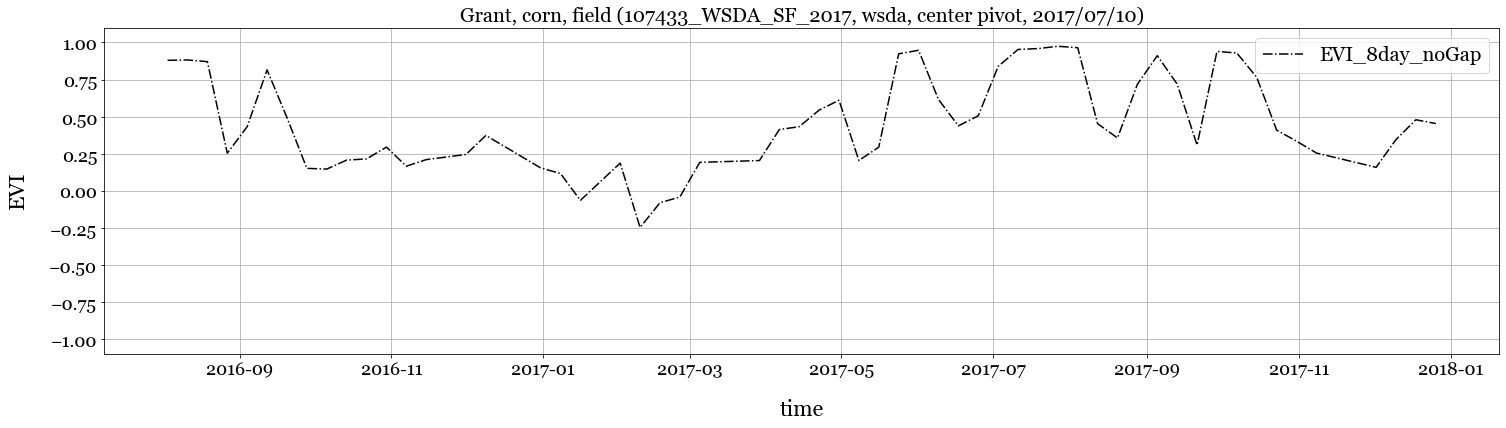

In [15]:
curr_ID = EVI_8day_IDS[2]
EVI_8day_noGap_field = EVI_8day_noGap[EVI_8day_noGap.ID == curr_ID].copy()

plt.figure()

fig, ax = plt.subplots()
fig.set_size_inches(25, 6)

################################################
#
#   plot the data
#

x = EVI_8day_noGap_field.human_system_start_time.values
y = EVI_8day_noGap_field.EVI.values
ax.plot(x, y, '-k', ls='-.', label = 'EVI_8day_noGap')


################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = label_FontSize, labelpad=20);
ax.set_ylabel('EVI', fontsize = label_FontSize, labelpad=20);
ax.tick_params(axis='y', which='major', labelsize = tick_FontSize)
ax.tick_params(axis='x', which='major', labelsize = tick_FontSize)
ax.legend(loc="best", fontsize=20);
ax.set_ylim([-1.1, 1.1])
# ax2.set_xlim([0, 2000])


a_title = EVI_8day_noGap_field.county.unique()[0] + ", " + \
          EVI_8day_noGap_field.CropTyp.unique()[0] + " (" + \
          EVI_8day_noGap_field.ID.unique()[0] +  ", " + \
          EVI_8day_noGap_field.DataSrc.unique()[0] +  ", " + \
          EVI_8day_noGap_field.Irrigtn.unique()[0] +  ", " + \
          EVI_8day_noGap_field.LstSrvD.unique()[0] +  ")"

ax.set_title(a_title, fontsize=20);
ax.grid(True)

file_name = data_dir + curr_ID + "noGap.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)
plt.show()

# Apply SG method

In [16]:
EVI_8day_noGap["SG_EVI"] = 0

# Savitky-Golay parameters:
window_len = 7
poly_order = 3

In [17]:
for a_field in EVI_8day_IDS:
    curr_field = EVI_8day_noGap[EVI_8day_noGap.ID == a_field].copy()
    curr_idx = EVI_8day_noGap[EVI_8day_noGap.ID == a_field].index.values
    
    y = curr_field.EVI.values
    SG_pred = scipy.signal.savgol_filter(y, window_length = window_len, polyorder = poly_order)
    
    EVI_8day_noGap.loc[curr_idx, "SG_EVI"] = SG_pred

# SG might violate the boundaries. clip them:

In [18]:
upper_viol_idx = EVI_8day_noGap[EVI_8day_noGap.SG_EVI > 1 ].index.values
EVI_8day_noGap.loc[upper_viol_idx, "SG_EVI"] = 1

lower_viol_idx = EVI_8day_noGap[EVI_8day_noGap.SG_EVI <- 1 ].index.values
EVI_8day_noGap.loc[lower_viol_idx, "SG_EVI"] = -1

# Plot smoothed vs. non-smooth

<Figure size 720x864 with 0 Axes>

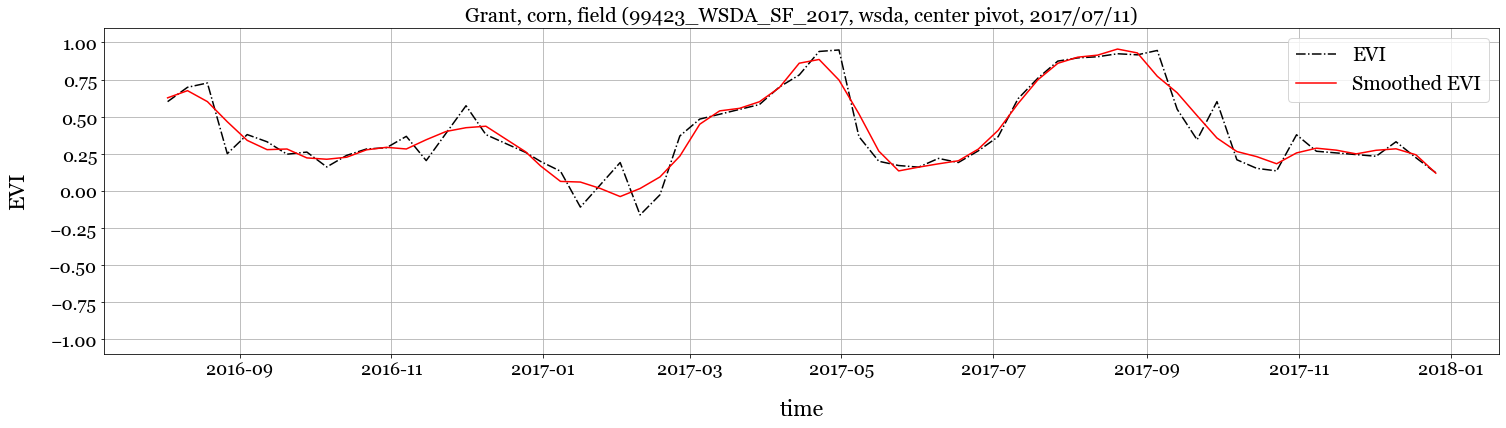

In [19]:
curr_ID = EVI_8day_IDS[1]
EVI_8day_noGap_field = EVI_8day_noGap[EVI_8day_noGap.ID == curr_ID].copy()

plt.figure()

fig, ax = plt.subplots()
fig.set_size_inches(25, 6)

################################################
#
#   plot the data
#

x = EVI_8day_noGap_field.human_system_start_time.values
y = EVI_8day_noGap_field.EVI.values
ax.plot(x, y, '-k', ls='-.', label = 'EVI')

x = EVI_8day_noGap_field.human_system_start_time.values
y = EVI_8day_noGap_field.SG_EVI.values
ax.plot(x, y, '-r', ls='-', label = 'Smoothed EVI')


################################################
#
# Set labels and ticks
#
ax.set_xlabel('time', fontsize = label_FontSize, labelpad = 20);
ax.set_ylabel('EVI', fontsize = label_FontSize, labelpad = 20);
ax.tick_params(axis = 'y', which = 'major', labelsize = tick_FontSize)
ax.tick_params(axis = 'x', which = 'major', labelsize = tick_FontSize)
ax.legend(loc="best", fontsize=20);
ax.set_ylim([-1.1, 1.1])
# ax2.set_xlim([0, 2000])


a_title = EVI_8day_noGap_field.county.unique()[0] + ", " + \
          EVI_8day_noGap_field.CropTyp.unique()[0] + " (" + \
          EVI_8day_noGap_field.ID.unique()[0] +  ", " + \
          EVI_8day_noGap_field.DataSrc.unique()[0] +  ", " + \
          EVI_8day_noGap_field.Irrigtn.unique()[0] +  ", " + \
          EVI_8day_noGap_field.LstSrvD.unique()[0] +  ")"

ax.set_title(a_title, fontsize=20);
ax.grid(True)

file_name = data_dir + curr_ID + "noGap.png"
# plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)
plt.show()

# Plot fine granular and SOS/EOS

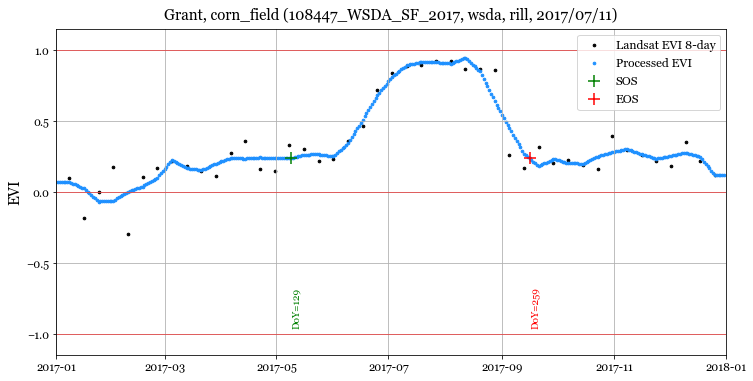

In [24]:
curr_ID = EVI_8day_IDS[0]
EVI_8day_noGap_field = EVI_8day_noGap[EVI_8day_noGap.ID == curr_ID].copy()

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 10}

plt.rcParams.update(params)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});


ax1.grid(True);

rcp.plot_for_landsat_proposal(twoYears_EVI8Day = EVI_8day_noGap_field, 
                                SFYr=2017, 
                                ax = ax1, 
                                onset_cut=0.3, offset_cut=0.3)
ax1.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])

file_name = data_dir + curr_ID + "_SOS.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)


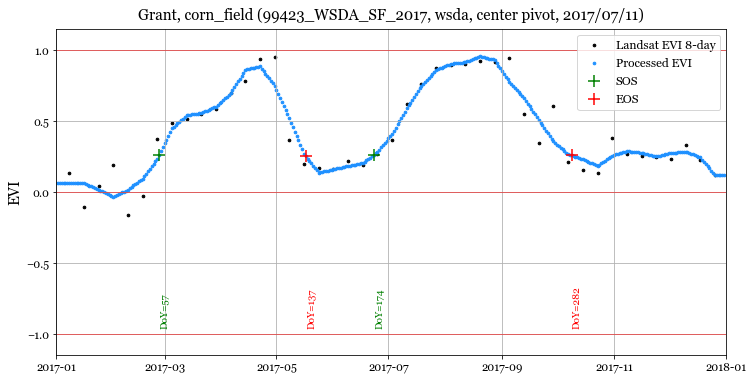

In [25]:
curr_ID = EVI_8day_IDS[1]
EVI_8day_noGap_field = EVI_8day_noGap[EVI_8day_noGap.ID == curr_ID].copy()

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});


ax1.grid(True);

rcp.plot_for_landsat_proposal(twoYears_EVI8Day = EVI_8day_noGap_field, 
                                SFYr=2017, 
                                ax = ax1, 
                                onset_cut=0.3, offset_cut=0.3)
ax1.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])

file_name = data_dir + curr_ID + "_SOS.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)


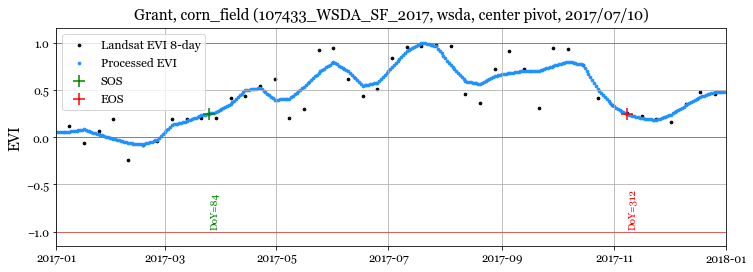

In [27]:
curr_ID = EVI_8day_IDS[2]
EVI_8day_noGap_field = EVI_8day_noGap[EVI_8day_noGap.ID == curr_ID].copy()

fig, ax1 = plt.subplots(1, 1, figsize=(12, 4),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});


ax1.grid(True);

rcp.plot_for_landsat_proposal(twoYears_EVI8Day = EVI_8day_noGap_field, 
                                SFYr=2017, 
                                ax = ax1, 
                                onset_cut=0.3, offset_cut=0.3)
ax1.set_xlim([datetime.date(2017, 1, 1), datetime.date(2018, 1, 1)])

file_name = data_dir + curr_ID + "_SOS.png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight', transparent=False)
